In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import numpy as np
from simulation_similarity_analysis.metrics import SimilarityMetric

In [16]:
RESULTS_FOLDER = 'results'
parameters = {
    "cell_cycle":"Duration of the cell cycle $t_{total}$",
    "average_healthy_glucose_absorption":"Average healthy glucose absorption $\mu_{g,healthy}$",
    "average_cancer_glucose_absorption":"Average cancer glucose absorption $\mu_{g,cancer}$",
    "average_healthy_oxygen_consumption":"Average healthy oxygen consumption $\mu_{o,healthy}$",
    "average_cancer_oxygen_consumption":"Average cancer oxygen consumption $\mu_{o,cancer}$"
             }
IMG_TYPES = {
    "cells_types":"Cell type", 
    "cells_densities": "Cell density", 
    "oxygen": "Oxygen density", 
    "glucose": "Glucose density",
}
EVALUATION_FILE = "evaluation_stats.csv"

# Plot results

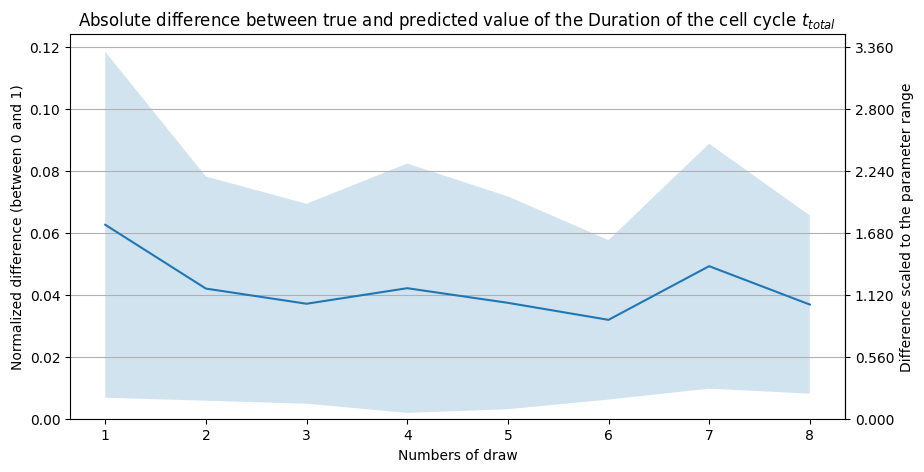

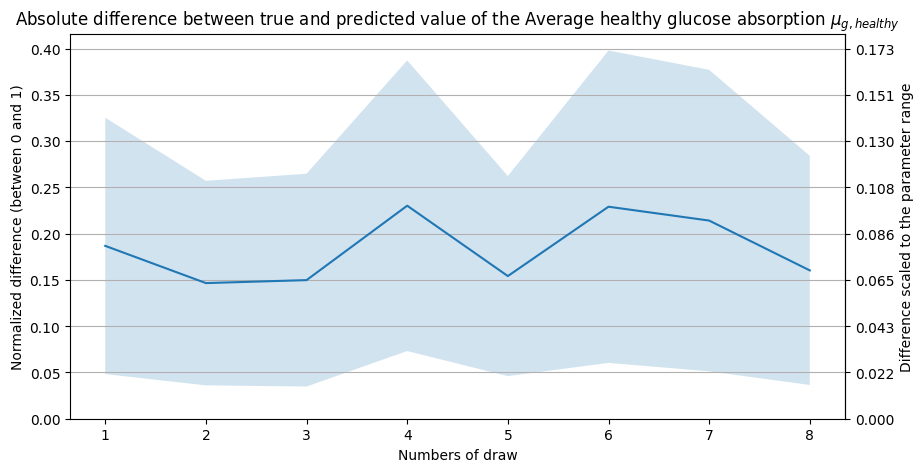

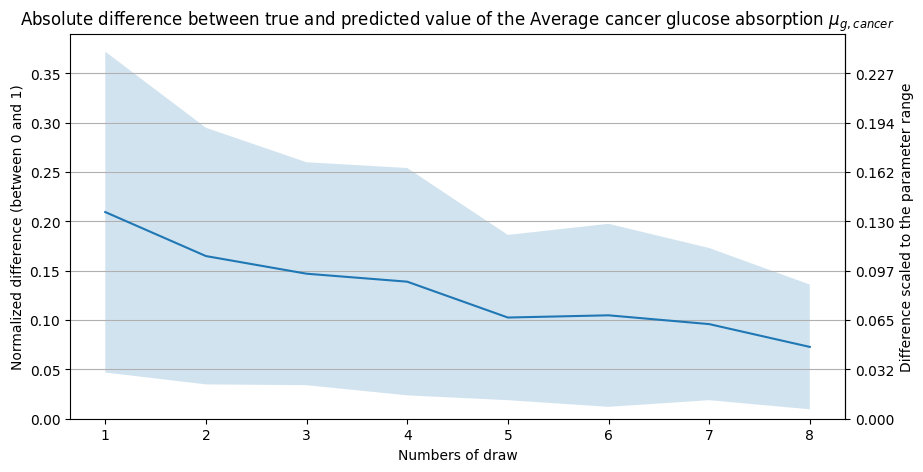

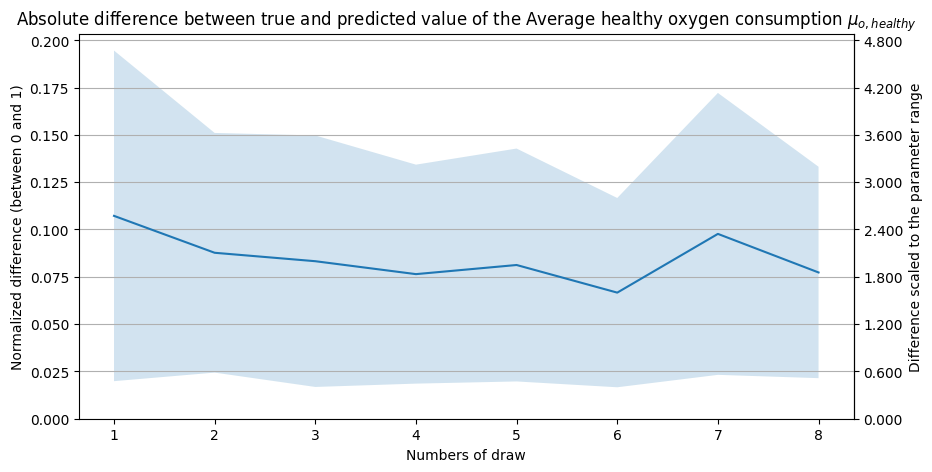

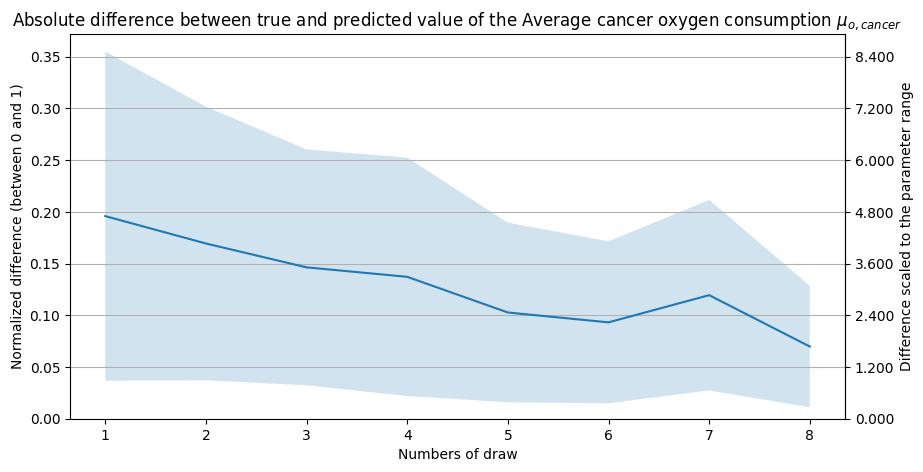

In [3]:
dataset = "no_dose"

# Find best indices
best_indices = dict()
for draw in range(1,9):
    df = pd.read_csv(os.path.join(RESULTS_FOLDER, f"hyp_search_{dataset}_for_{draw}_draws", "performances.csv"))
    best_indices[draw] = df["Performance"].idxmin()

param_ranges = pd.read_csv(os.path.join("simulation","parameter_data.csv"), index_col=0)

performances = dict()
for key, value in parameters.items():
    means = dict()
    stds = dict()
    for draw in range(1,9):
        df = pd.read_csv(os.path.join(RESULTS_FOLDER, f"hyp_search_no_dose_for_{draw}_draws", str(best_indices[draw]), "evaluation_stats.csv"))
        means[draw] = df.loc[df["Parameters"] == key, "Means"].iloc[0]
        stds[draw] = df.loc[df["Parameters"] == key, "Standard Deviation"].iloc[0]
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    X = means.keys()
    Y_mean = np.array(list(means.values()))
    Y_stds = np.array(list(stds.values()))
    ax.plot(X, Y_mean)
    ax.fill_between(X, Y_mean-Y_stds, Y_mean+Y_stds, alpha=0.2)
    plt.title(f"Absolute difference between true and predicted value of the {value}")
    ax.set_ylabel("Normalized difference (between 0 and 1)")
    ax.set_xlabel("Numbers of draw")
    ax.grid(axis='y')
    ax.set_ylim(0, None)
    ax2 = ax.secondary_yaxis("right")
    min = param_ranges.loc[key]["Minimum"]
    max = param_ranges.loc[key]["Maximum"]
    
    performances[key] = Y_mean*(max-min)
    
    ticks = np.array(ax.get_yticks())*(max-min)
    ax2.set_yticks(ax.get_yticks(), [f"{tick:.3f}" for tick in ticks])
    ax2.set_ylabel(f"Difference scaled to the parameter range")
    plt.savefig(os.path.join("pictures", f"Performance for {dataset} {key}.pdf"))
    

# Similarity between matrices linked to score

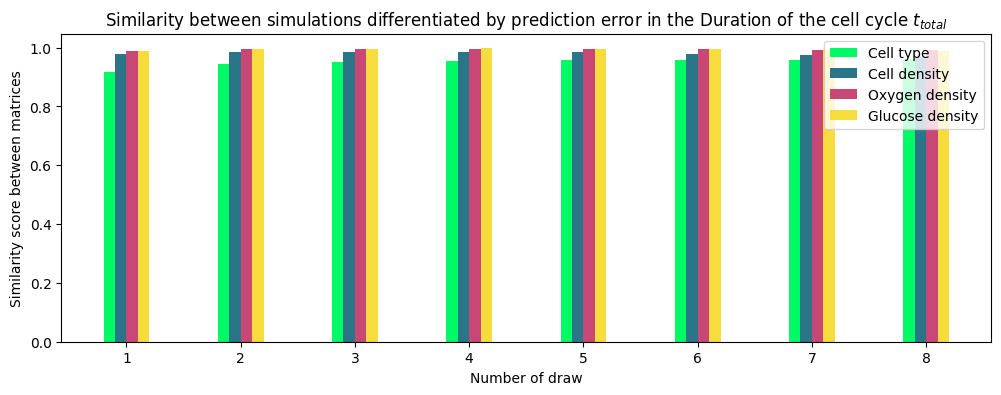

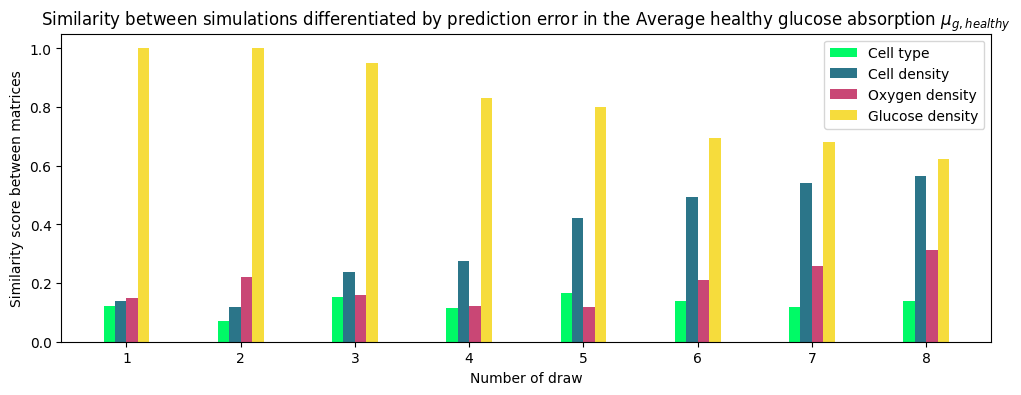

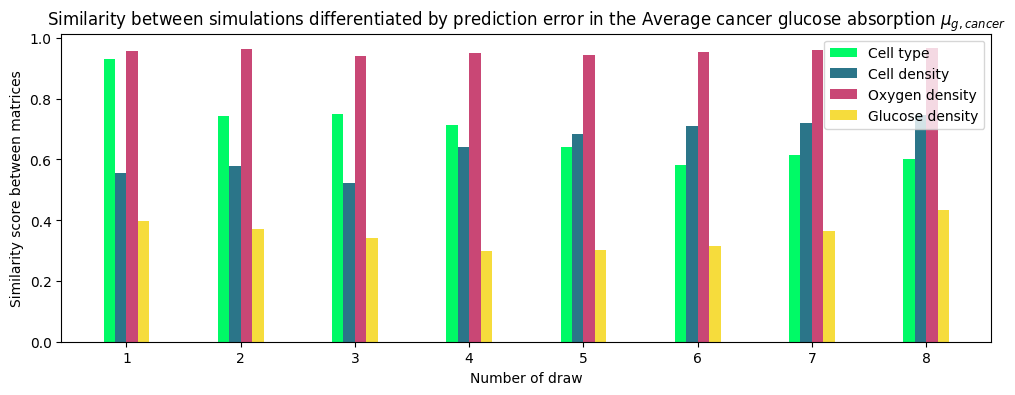

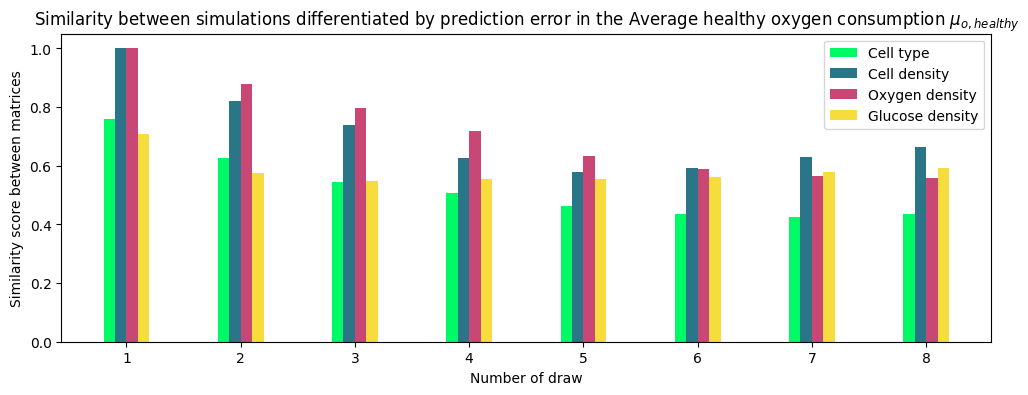

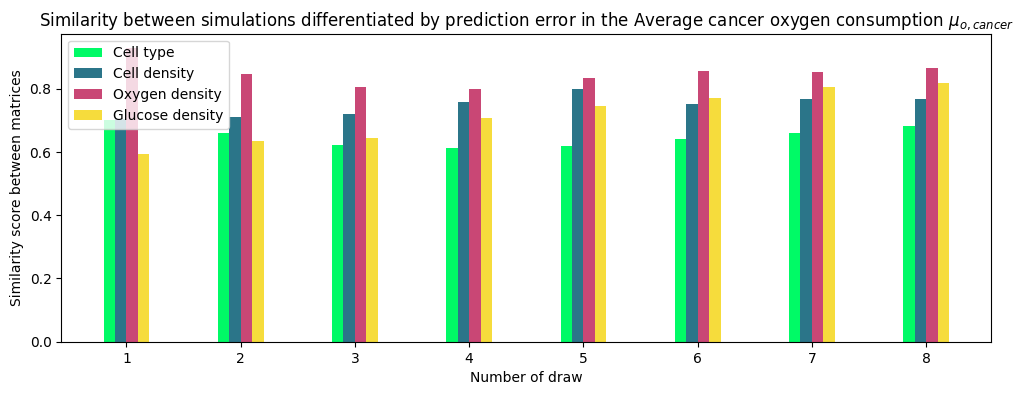

In [23]:
best_doses_analysis = pd.read_csv(os.path.join("simulation_similarity_analysis","no_dose_analysis","similarity_between_matrix","scalar_similarity.csv"),index_col=0)
def get_evolution(img_type, param, draw):
    metric = SimilarityMetric.JACCARD if img_type=="cells_types" else SimilarityMetric.INTERSECTION_HISTOGRAM
    data = best_doses_analysis.loc[(best_doses_analysis["Timestep"] == draw) & (best_doses_analysis["Img_Type"]==img_type) & (best_doses_analysis["Parameter"]==param) & (best_doses_analysis["Metric"]==metric.__str__()), ["Difference", "Mean_Similarity_Measure","Std_Similarity_Measure"]]
    means = {diff:data.loc[data["Difference"]==diff, "Mean_Similarity_Measure"].iloc[0] for diff in data["Difference"].tolist()}
    stds = {diff:data.loc[data["Difference"]==diff, "Std_Similarity_Measure"].iloc[0] for diff in data["Difference"].tolist()}

    max = np.max(list(means.values()))
    min = np.min(list(means.values()))
    means_scaled = {key:(value-min)/(max-min) for key,value in means.items()}
    stds_scaled = {key:value/(max-min) for key,value in stds.items()}
    return means_scaled, stds_scaled

barWidth = 0.1
colors = {
    "cells_types":"#00FA66ff",
    "cells_densities":"#2B7589ff",
    "oxygen":"#C94775ff",
    "glucose":"#F6DC3Cff"
}
for key, value in parameters.items():
    perf = performances[key]
    fig = plt.figure(figsize=(12,4))
    for i, img_type in enumerate(IMG_TYPES.keys()):
        X = [x + i*barWidth for x in range(8)]
        similarity_per_draw = np.zeros(8)
        for j, draw in enumerate(range(350,1150, 100)):
            m,s = get_evolution(img_type, key, draw)
            key_as_array = np.asarray(list(m.keys()))
            nearest_key = key_as_array[(np.abs(key_as_array - perf[j])).argmin()]
            similarity = m[nearest_key]
            similarity_per_draw[j:] += similarity
        for j in range(1,9):
            similarity_per_draw[j-1] /= j
        plt.bar(X ,similarity_per_draw, color=colors[img_type], width=barWidth, label=IMG_TYPES[img_type])
    
    plt.ylabel("Similarity score between matrices")
    plt.xticks([r + (4/2-0.5)*barWidth for r in range(8)], [str(i) for i in range(1,9)])
    plt.xlabel("Number of draw")
    plt.title(f"Similarity between simulations differentiated by prediction error in the {value}")
    plt.legend()
    plt.savefig(os.path.join("pictures",f"similarity_perf_{key}.png"))

# Hyperparameter tuning

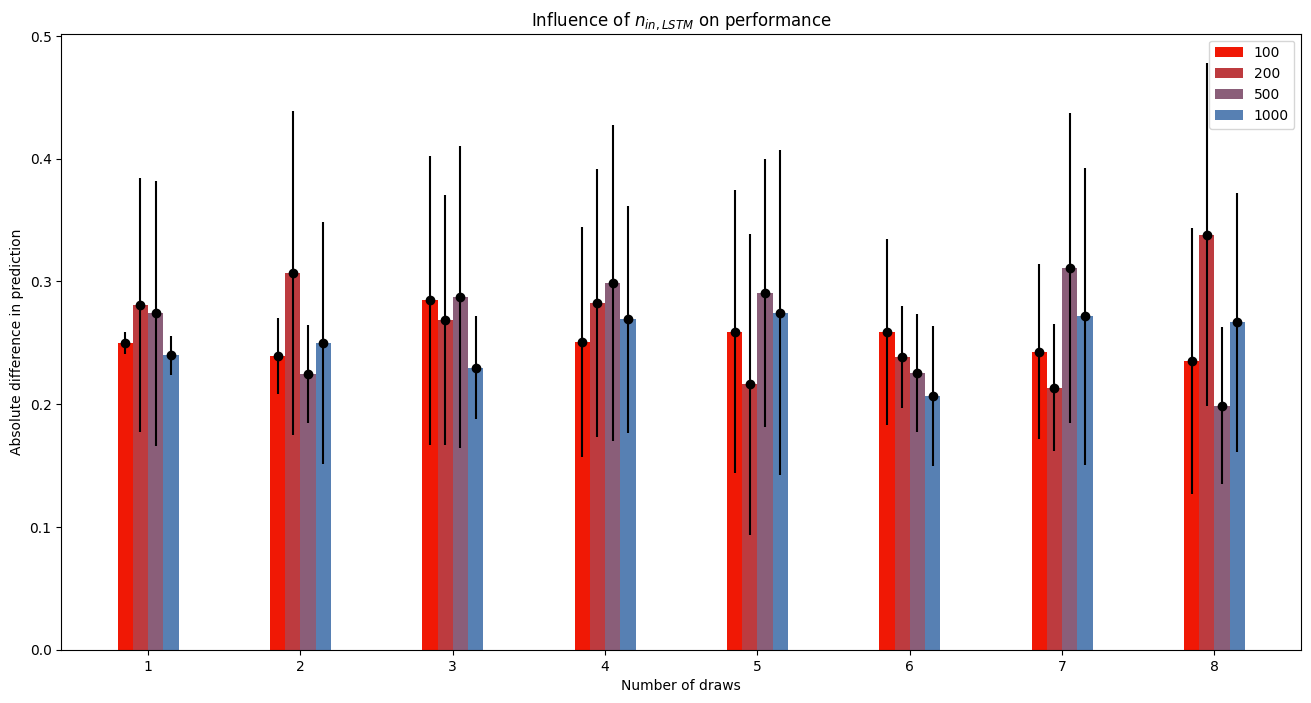

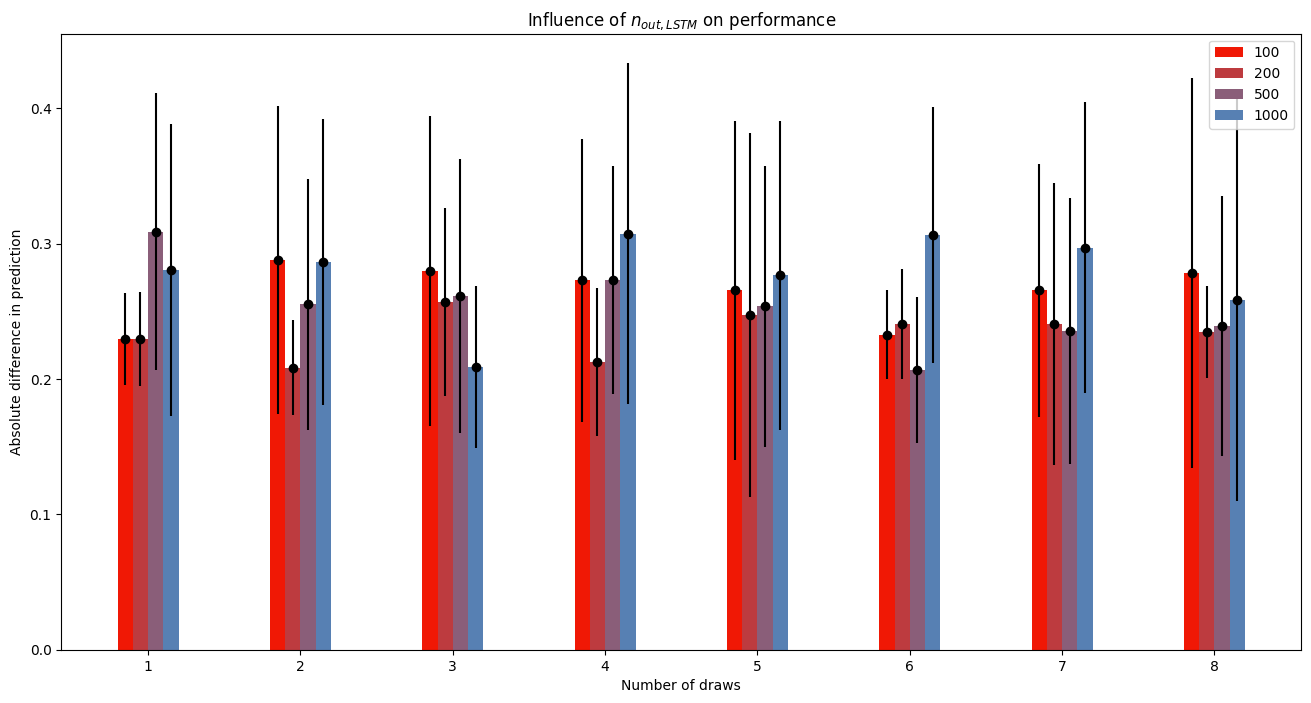

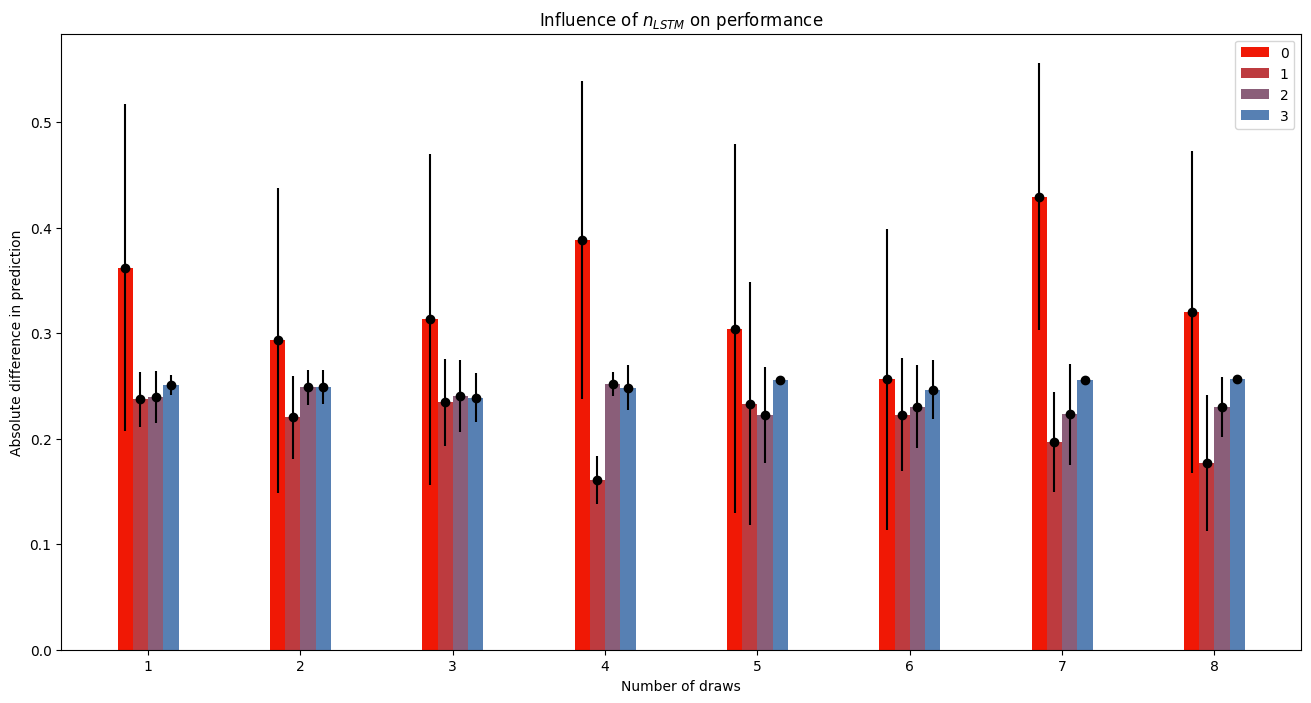

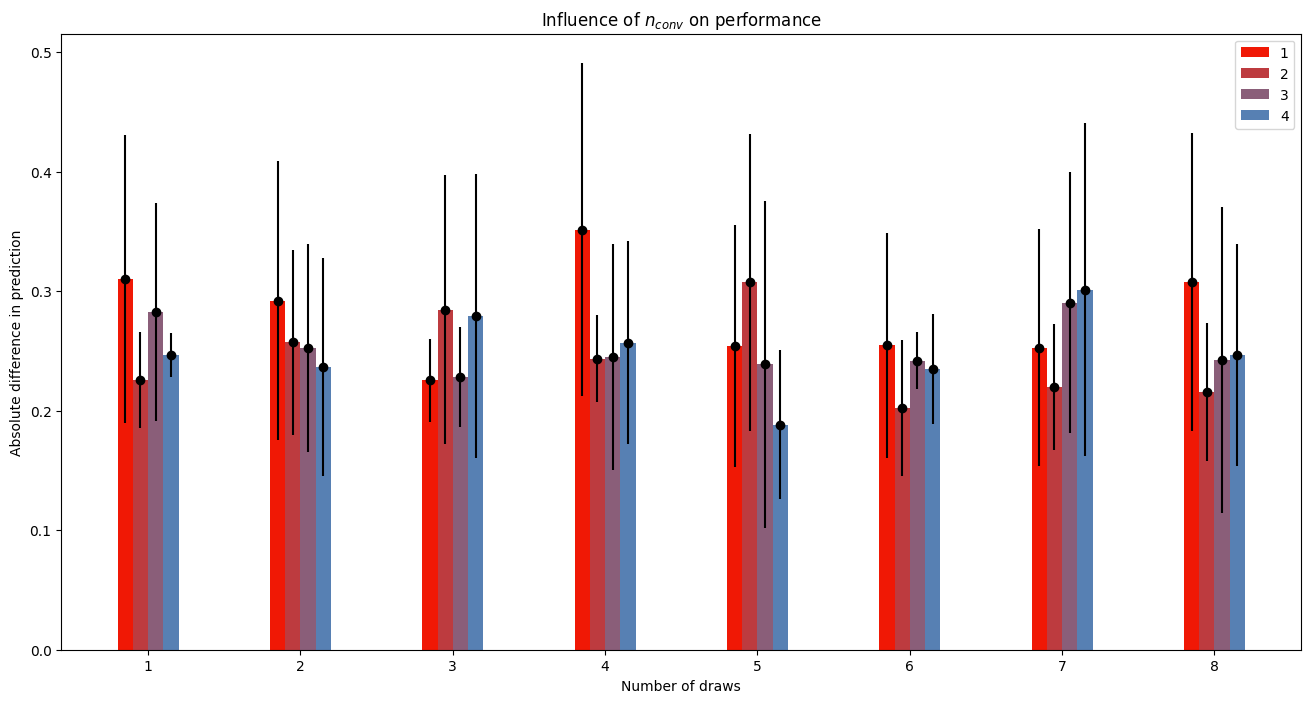

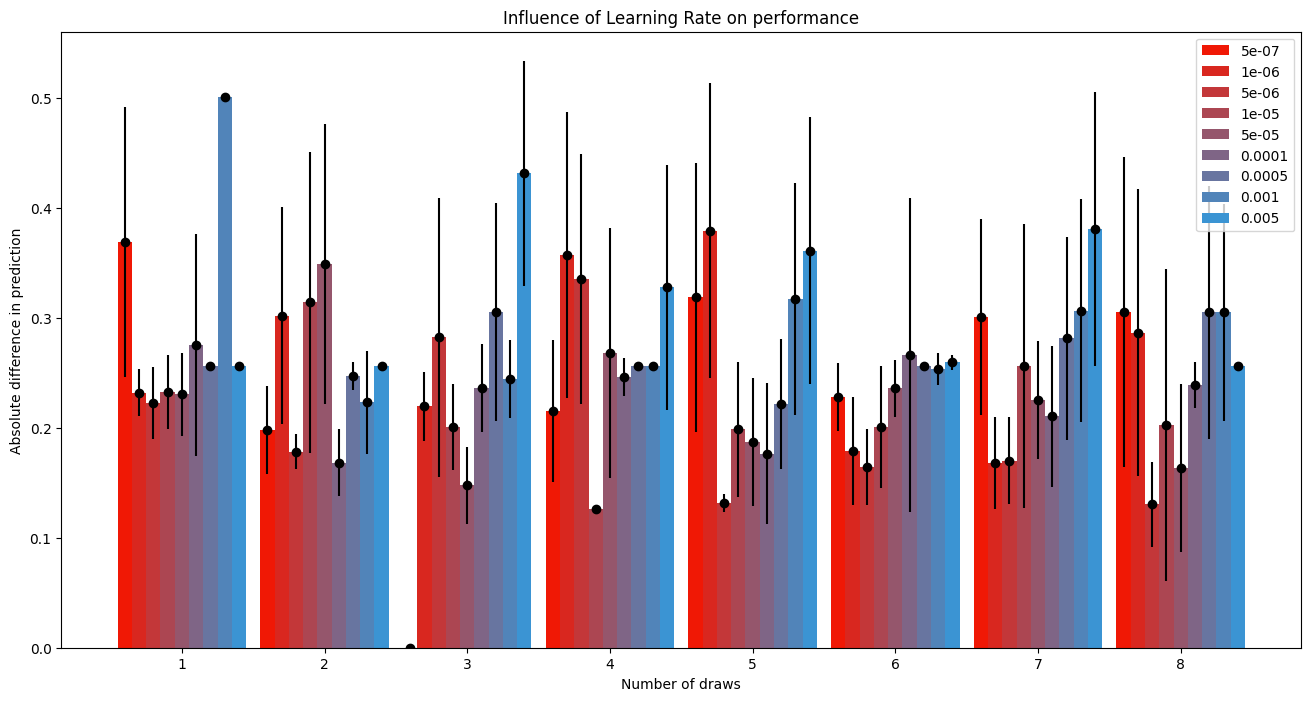

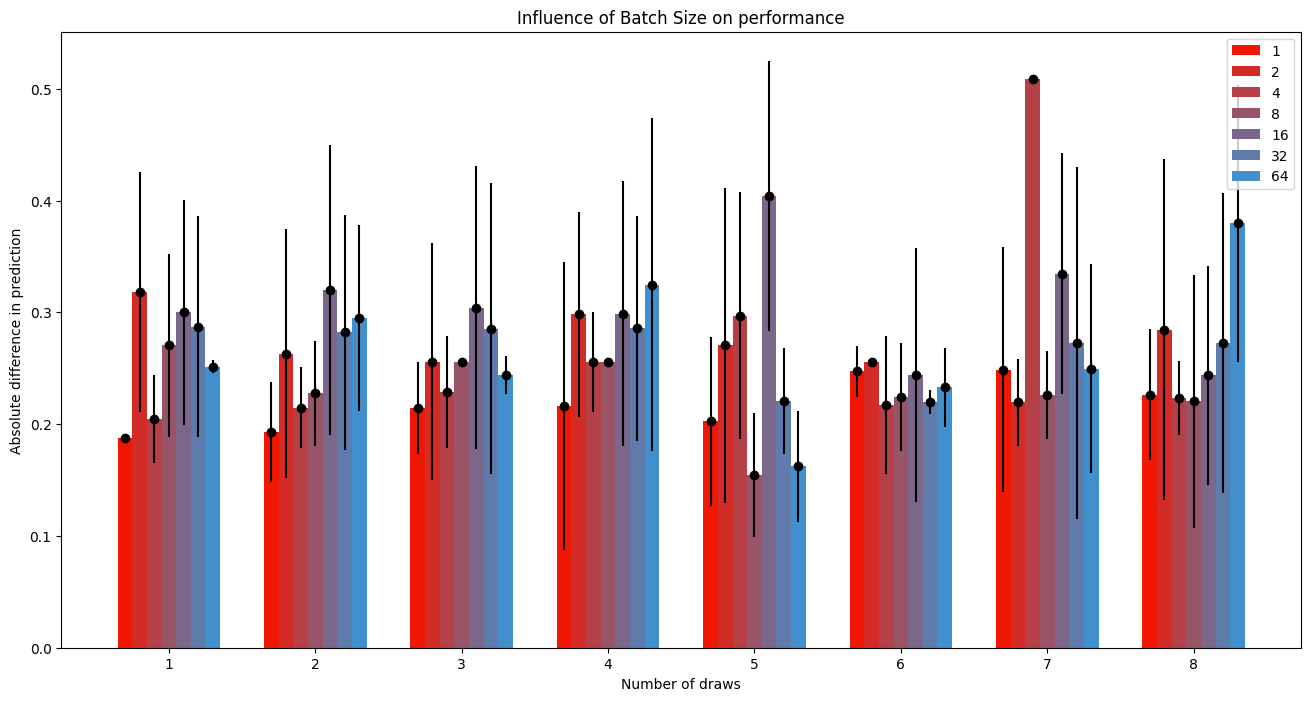

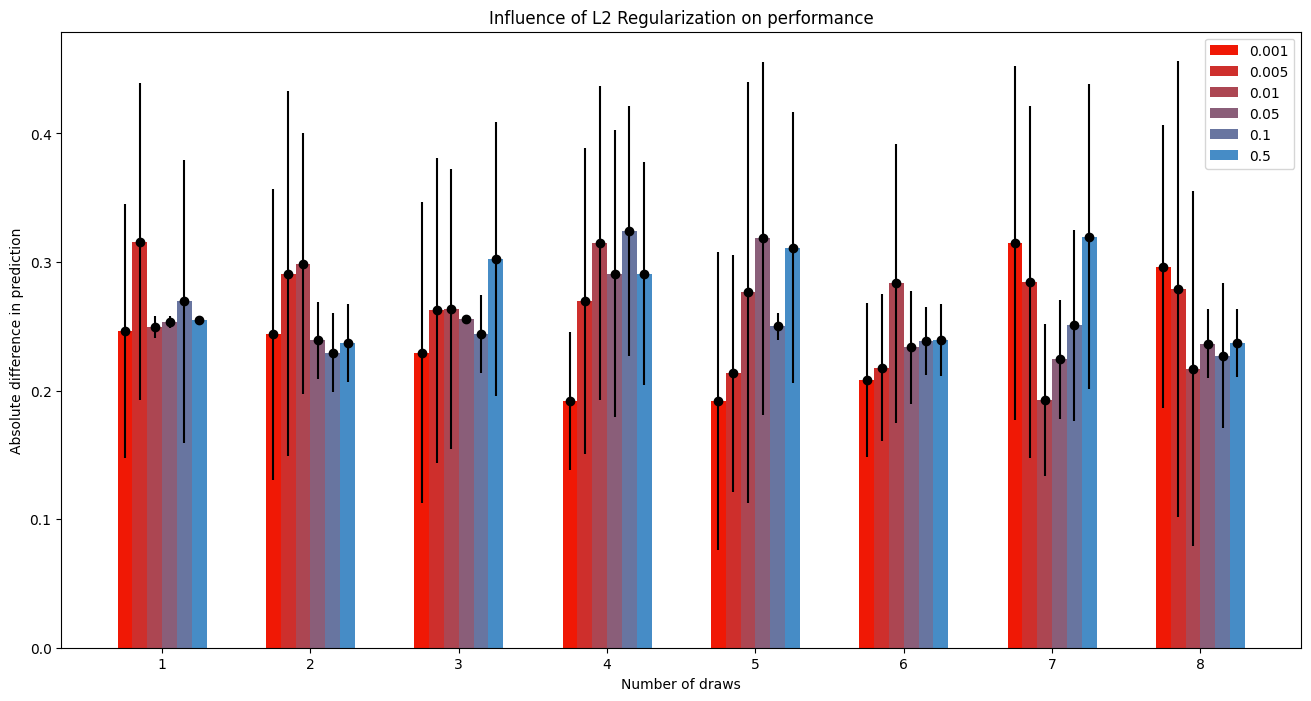

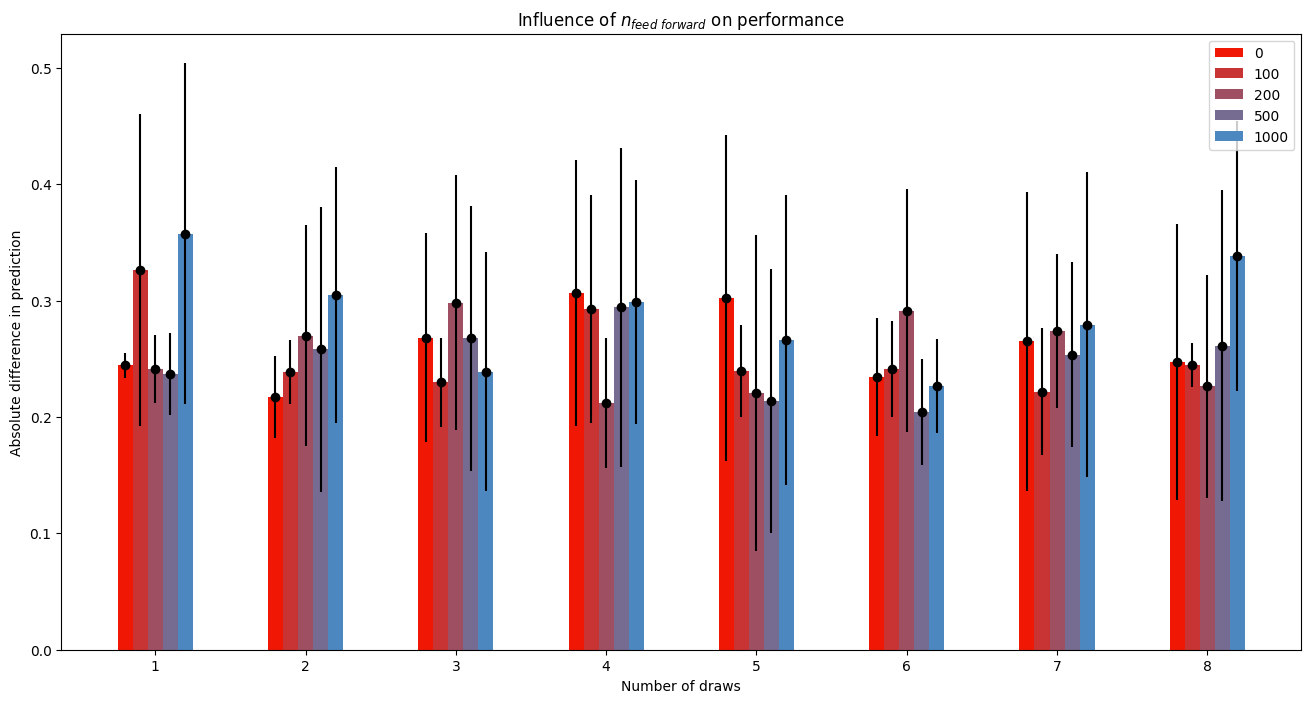

In [63]:
parameters_to_study = {
    "INPUT_LSTM":"$n_{in, LSTM}$",
    "OUTPUT_LSTM":"$n_{out, LSTM}$",
    "LSTM_LAYERS":"$n_{LSTM}$",
    "CONV_LAYERS":"$n_{conv}$",
    "LEARNING_RATE":"Learning Rate",
    "BATCH_SIZE":"Batch Size",
    "L2_REGULARIZATION":"L2 Regularization",
    "FEED_FORWARD":"$n_{feed \ forward}$"}
dataframes = [pd.read_csv(os.path.join("results",f"hyp_search_no_dose_for_{draw}_draws", "performances.csv"), index_col=0) for draw in range(1,9)]

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

for parameter_to_study, name in parameters_to_study.items():
    possible_param_value = pd.concat(dataframes, ignore_index=True)[parameter_to_study].unique()
    barWidth = 0.1
    datas = {}
    for draw in range(1,9):
        datas[draw] = {param_value: list(dataframes[draw-1].loc[dataframes[draw-1][parameter_to_study]==param_value, 'Performance']) for param_value in possible_param_value}
    
    fig = plt.subplots(figsize =(16, 8)) 

    colors = [colorFader('#f01805','#24a3ed',j/len(possible_param_value)) for j in range(len(possible_param_value))]
    
    for i, param_value in enumerate(sorted(possible_param_value)):
        X = [x + i*barWidth for x in range(8)]
        Y_mean = [np.mean(datas[draw][param_value]) if len(datas[draw][param_value])!=0 else 0  for draw in range(1,9)]
        Y_std = [np.std(datas[draw][param_value]) if len(datas[draw][param_value])!=0 else 0 for draw in range(1,9)]
        plt.bar(X, Y_mean, label=param_value, width=barWidth, color=colors[i])
        plt.errorbar(X, Y_mean, yerr=Y_std, fmt='o', color='black')
    
    a = len(possible_param_value)
    plt.xticks([r + (a/2-0.5)*barWidth for r in range(8)], [str(i) for i in range(1,9)])
    plt.ylabel("Absolute difference in prediction")
    plt.xlabel("Number of draws")
    plt.title(f"Influence of {name} on performance")
    plt.legend()
    plt.savefig(os.path.join("pictures", f"{parameter_to_study}_influence.pdf"))